# Floquet optimization

In [1]:
try:
    get_ipython
    isnotebook = True
except:
    isnotebook = False

In [2]:
import os
import numpy as np
import qutip as qt
import nlopt
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image, display
if not isnotebook:
    def display(args):
        pass

In [3]:
import qocttools
import qocttools.pulses as pulses
import qocttools.qoct as qoct
import qocttools.hamiltonians as hamiltonians
import qocttools.floquet as floquet
import qocttools.target as target
qocttools.about()

Running qocttools version 0.0.1
    Project repository git hash = f5e4b4c9fdf2934ed3a69ac46f9d063ba620c1d6
    Project repository last commit date = 2023-01-22 09:47:57
    Project repository refs = floquet


In [4]:
if "NP_RANDOM_SEED" in os.environ:
    seed = int(os.environ["NP_RANDOM_SEED"])
else:
    seed = 1

In [5]:
data = []

# Model definition

In [6]:
Sx = qt.jmat(1, "x")
Sy = qt.jmat(1, "y")
Sz = qt.jmat(1, "z")
Bs = 0.3
Nz = 1.00
Nxy = 0.05
Bd = 0.1
omega = 1.00
gamma = 0.2
beta = 3.0
d = 3
dim = d**2

In [7]:
def system_definition():
    H0 = -Bs * Sz + Nz * Sz**2 + Nxy * (Sx**2 - Sy**2)
    Vx = -Bd * Sx
    Vy = -Bd * Sy
    A = []
    e, psi = H0.eigenstates()
    for i in range(d):
        for j in range(d):
            if j == i:
                continue
            gammaij = gamma * np.exp(-beta*e[j]) / (np.exp(-beta*e[i])+np.exp(-beta*e[j]))
            A.append( np.sqrt(gammaij) * psi[j] * psi[i].dag())
    return H0, [Vx, Vy], A, e, psi

H0, V, A, e, psi = system_definition()

In [8]:
print("Field-free eigenvalues = {}".format(e))

Field-free eigenvalues = [0.         0.69586187 1.30413813]


# Basic freequency and period

In [9]:
#omega_eV = 2.0
#omega = omega_eV / eV
omega = 3.0
T = (2.0*np.pi/omega)

print("The periodic driving frequency is {} eV.".format(omega))
print("The Floquet period is {} a.u".format(T))


The periodic driving frequency is 3.0 eV.
The Floquet period is 2.0943951023931953 a.u


# Zero-field calculation

In [10]:
a0 = 0.0

def Axref(t, args):
    return a0 * np.sin(omega * t)

def Ayref(t, args):
    return a0 * np.cos(omega * t)

In [11]:
H = [H0, [V[0], Axref], [V[1], Ayref]]

In [12]:
epsilon0 = floquet.epsilon(H, T)
print("Field-free Floquet pseudoenergies = {}".format(epsilon0))

Field-free Floquet pseudoenergies = [-0.          0.69586183  1.30413808]


# Non-zero field (reference) calculations

In [13]:
a0 = 5.0

In [14]:
#print(qt.floquet_modes(H, T)[1])
epsilon_ref = floquet.epsilon(H, T)
print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
print("Field-free Floquet pseudoenergies = {}".format(epsilon0))
print("Diff with the field-free eigenvalues = {}".format(epsilon_ref-epsilon0))

Reference Floquet pseudoenergies = [0.037835   0.72888143 1.23328365]
Field-free Floquet pseudoenergies = [-0.          0.69586183  1.30413808]
Diff with the field-free eigenvalues = [ 0.037835    0.0330196  -0.07085443]


# Pulse definitions

In [15]:
times = np.linspace(0, T, 100)
maxamp = a0 * np.sqrt(T) / 2

read_initial_guess_from_disk = True

In [16]:
if not read_initial_guess_from_disk:
    
    M = 5
    random_initial_pulse = True

    if random_initial_pulse:
        random_bound = 1.0 * maxamp
        u1 = np.zeros(2*M+1)
        u1[1:] = np.random.uniform(low = -1.0, high = 1.0, size = 2*M)
        u1[1:] = random_bound * u1[1:]
        u2 = np.zeros(2*M+1)
        u2[1:] = np.random.uniform(low = -1.0, high = 1.0, size = 2*M)
        u2[1:] = random_bound * u2[1:]
    else:
        u1 = np.zeros(2*M+1)
        u1[7] = maxamp
        u2 = np.zeros(2*M+1)
        u2[8] = maxamp
    
    Ax0 = pulses.pulse("fourier", T, u = u1)
    Ay0 = pulses.pulse("fourier", T, u = u2)
    Axopt = pulses.pulse("fourier", T, u = u1)
    Ayopt = pulses.pulse("fourier", T, u = u2)
    #Axr = pulses.pulse("fourier", T, u = u1)
    #Ayr = pulses.pulse("fourier", T, u = u2)
    #uopt = Axr.fitparams(Axref(times, None), times, u1)
    #Axr.set_parameters(uopt)
    #uopt = Ayr.fitparams(Ayref(times, None), times, u2)
    #Ayr.set_parameters(uopt)
    Ax0.print('Ax0')
    Ay0.print('Ay0')
else:
    Ax0 = pulses.read_pulse('Ax0')
    Ay0 = pulses.read_pulse('Ay0')
    Axopt = pulses.read_pulse('Ax0')
    Ayopt = pulses.read_pulse('Ay0')

#Axopt.set_constraint('zero_average')
#Ayopt.set_constraint('zero_average')

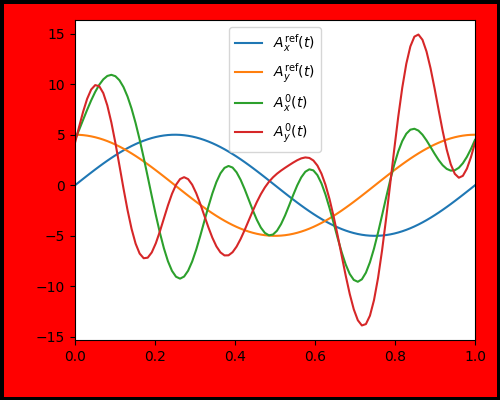

In [17]:
fig = plt.figure(figsize=(5,4), facecolor = 'red', frameon = True, edgecolor = 'black', linewidth = 5)
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

times = np.linspace(0, T, 100)

ax.plot(times/T, Axref(times, None), label = r"$A^{\rm ref}_x(t)$")
ax.plot(times/T, Ayref(times, None), label = r"$A^{\rm ref}_y(t)$")

ax.plot(times/T, Ax0.fu(times), label = r"$A^{\rm 0}_x(t)$")
ax.plot(times/T, Ay0.fu(times), label = r"$A^{\rm 0}_y(t)$")

#ax.plot(times/T, Axref(times, None))
#ax.plot(times/T, Ayref(times, None))

ax.legend()
ax.set_xlim(left = 0, right = 1)

fname = 'reference-fields'
fig.savefig(fname + '.pdf')
fig.savefig(fname + '.png')
plt.close(fig)
display(Image(fname + '.png'))

In [18]:
u0 = pulses.pulse_collection_get_parameters([Ax0, Ay0])

# Hamiltonian

In [19]:
H = hamiltonians.hamiltonian(H0, V)

In [20]:
def Hfunc(t, args):
    fx = args["f"][0]
    fy = args["f"][1]
    return H0 + fx(t)*V[0] + fy(t)*V[1]

def Vfuncx(t, args):
    return V[0]

def Vfuncy(t, args):
    return V[1]

H_ = hamiltonians.hamiltonian(Hfunc, [Vfuncx, Vfuncy])

# Initial-guess calculations

In [21]:
u = u0.copy()

In [22]:
epsilon_ig = floquet.epsilon3(H, [Ax0, Ay0], u, T)
print("Initial-guess Floquet pseudoenergies = {}".format(epsilon_ig))
print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
print("Diff = {}".format(epsilon_ig-epsilon_ref))

Initial-guess Floquet pseudoenergies = [0.03532869 0.7054971  1.25917426]
Reference Floquet pseudoenergies = [0.037835   0.72888143 1.23328365]
Diff = [-0.00250631 -0.02338433  0.02589061]


In [23]:
epsilon_ig = floquet.epsilon3(H_, [Ax0, Ay0], u, T)
print("Initial-guess Floquet pseudoenergies = {}".format(epsilon_ig))
print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
print("Diff = {}".format(epsilon_ig-epsilon_ref))

Initial-guess Floquet pseudoenergies = [0.03532869 0.7054971  1.25917426]
Reference Floquet pseudoenergies = [0.037835   0.72888143 1.23328365]
Diff = [-0.00250631 -0.02338433  0.02589061]


# Target definition

In [24]:
targeteps = epsilon_ref.reshape(1, 3)

In [25]:
target_def = 0

if target_def == 0:
    
    def f(eps):
        cte = 1.0
        fval = 0.0
        nkpoints = eps.shape[0]
        targete = targeteps
        dim = eps.shape[1]
        fval = 0.0
        for k in range(nkpoints):
            for alpha in range(dim):
                fval = fval - cte * (eps[k, alpha] - targete[k, alpha])**2
        return fval
    
    def dfdepsilon(eps):
        cte = 1.0
        nkpoints = eps.shape[0]
        targete = targeteps
        dim = eps.shape[1]
        dfval = np.zeros((nkpoints, dim))
        for k in range(nkpoints):
            for alpha in range(dim):
                dfval[k, alpha] = - 2.0 * cte * (eps[k, alpha]-targete[k, alpha])
        return dfval
    
elif target_def == 1:

    def f(eps):
        fval = 0.0
        dim = eps.shape[1]
        nkpoints = eps.shape[0]
        for k in range(nkpoints):
            fval = fval + eps[k, 0]-eps[k, 2]
        return fval

    def dfdepsilon(eps):
        dim = eps.shape[1]
        nkpoints = eps.shape[0]
        dfval = np.zeros((nkpoints, dim))
        for k in range(nkpoints):
            dfval[k, 0] = 1.0
            dfval[k, 1] = 0.0
            dfval[k, 2] = -1.0
        return dfval

# Optimization: Perturbation-theory formula

In [26]:
u = u0.copy()
pulses.pulse_collection_set_parameters([Axopt, Ayopt], u)

In [27]:
U0 = qt.qeye(3)
U0set = []
#for k in range(targetset.nkpoints):
U0set.append(U0)

In [28]:
tg = target.Target('floquet', targeteps = targeteps,
                   T = T, fepsilon = f, dfdepsilon = dfdepsilon)
#tg = target.Target('floquet', targeteps = targeteps, T = T)

In [29]:
opt = qoct.Qoct(H, T, times.shape[0], tg, [Axopt, Ayopt], U0set, floquet_mode = 'pt')
print("G(u) = {} (initial guess)".format(opt.gfunc(u)))

G(u) = -0.0012234324867341556 (initial guess)


In [30]:
check_gradient = True
if check_gradient:
    #u = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    derqoct, dernum, error = opt.check_grad(u)
    print("QOCT calculation: \t{}".format(derqoct))
    print("Ridders calculation: \t{} +- {}".format(dernum, error))
    data.append(derqoct)

optimize = False

if optimize:
    x, optval, res = opt.maximize(maxeval = 100,
                                  verbose = True,
                                  #tolerance = -1.0,
                                  #algorithm = nlopt.LD_MMA,
                                  algorithm = nlopt.LD_SLSQP,
                                  #algorithm = nlopt.LN_BOBYQA,
                                  #algorithm = nlopt.GD_STOGO,
                                  #algorithm = nlopt.LD_LBFGS,
                                  upper_bounds = 1 * np.abs(maxamp * np.ones_like(u)),
                                  lower_bounds = -1 * np.abs(maxamp * np.ones_like(u)))
    data.append(optval)
    uopt = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    print(opt.gfunc(uopt))
    epsilon_opt1 = floquet.epsilon3(H, [Axopt, Ayopt], uopt, T)
    print("Optimized Floquet pseudoenergies = {}".format(epsilon_opt1))
    print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
    print("Diff = {}".format(epsilon_opt1-epsilon_ref))

Computed the gradient with the QOCT formula. Elapsed time = 0.2032911777496338 s.
Will compute the 12 component of the gradient (the largest one).
G(u) = -0.0012353671425262879 . Elapsed time = 0.013167381286621094 s.
G(u) = -0.0012115545037286383 . Elapsed time = 0.014441490173339844 s.
G(u) = -0.0012319514564847261 . Elapsed time = 0.011246919631958008 s.
G(u) = -0.0012149423979629045 . Elapsed time = 0.016556978225708008 s.
G(u) = -0.0012295145131536898 . Elapsed time = 0.02745366096496582 s.
G(u) = -0.0012173650721610542 . Elapsed time = 0.01490640640258789 s.
QOCT calculation: 	-0.0011906239935038942
Ridders calculation: 	-0.0011906363430327597 +- 4.4031502821010454e-09


# Optimization: Perturbation-theory formula, Hamiltonian-as-a-function

In [31]:
u = u0.copy()
pulses.pulse_collection_set_parameters([Axopt, Ayopt], u)

In [32]:
U0 = qt.qeye(3)
U0set = []
#for k in range(targetset.nkpoints):
U0set.append(U0)

In [33]:
tg = target.Target('floquet', targeteps = targeteps,
                   T = T, fepsilon = f, dfdepsilon = dfdepsilon)
#tg = target.Target('floquet', targeteps = targeteps, T = T)

In [34]:
opt = qoct.Qoct(H_, T, times.shape[0], tg, [Axopt, Ayopt], U0set, floquet_mode = 'pt')
print("G(u) = {} (initial guess)".format(opt.gfunc(u)))

G(u) = -0.001223432486734294 (initial guess)


In [35]:
check_gradient = True
if check_gradient:
    #u = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    derqoct, dernum, error = opt.check_grad(u)
    print("QOCT calculation: \t{}".format(derqoct))
    print("Ridders calculation: \t{} +- {}".format(dernum, error))
    data.append(derqoct)

Computed the gradient with the QOCT formula. Elapsed time = 4.850576400756836 s.
Will compute the 12 component of the gradient (the largest one).
G(u) = -0.0012353671425262267 . Elapsed time = 0.25832533836364746 s.
G(u) = -0.0012115545037285525 . Elapsed time = 0.22982263565063477 s.
G(u) = -0.0012319514564846693 . Elapsed time = 0.21710515022277832 s.
G(u) = -0.0012149423979627783 . Elapsed time = 0.36176586151123047 s.
G(u) = -0.0012295145131538403 . Elapsed time = 0.2389209270477295 s.
G(u) = -0.001217365072160931 . Elapsed time = 0.23816514015197754 s.
QOCT calculation: 	-0.0011906245388211853
Ridders calculation: 	-0.001190636343041389 +- 4.4031576754925e-09


In [36]:
optimize = False

if optimize:
    x, optval, res = opt.maximize(maxeval = 100,
                                  verbose = True,
                                  #tolerance = -1.0,
                                  #algorithm = nlopt.LD_MMA,
                                  algorithm = nlopt.LD_SLSQP,
                                  #algorithm = nlopt.LN_BOBYQA,
                                  #algorithm = nlopt.GD_STOGO,
                                  #algorithm = nlopt.LD_LBFGS,
                                  upper_bounds = 1 * np.abs(maxamp * np.ones_like(u)),
                                  lower_bounds = -1 * np.abs(maxamp * np.ones_like(u)))
    data.append(optval)
    uopt = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    print(opt.gfunc(uopt))
    epsilon_opt1 = floquet.epsilon3(H, [Axopt, Ayopt], uopt, T)
    print("Optimized Floquet pseudoenergies = {}".format(epsilon_opt1))
    print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
    print("Diff = {}".format(epsilon_opt1-epsilon_ref))

# Optimization: QOCT formula

In [37]:
u = u0.copy()
pulses.pulse_collection_set_parameters([Axopt, Ayopt], u)

In [38]:
U0 = qt.qeye(3)
U0set = []
#for k in range(targetset.nkpoints):
U0set.append(U0)

In [39]:
#tg = target.Target('floquet', targeteps = targeteps, T = T)
tg = target.Target('floquet', targeteps = targeteps,
                   T = T, fepsilon = f, dfdepsilon = dfdepsilon)

In [40]:
opt = qoct.Qoct(H, T, times.shape[0], tg, [Axopt, Ayopt], U0set, floquet_mode = 'qoct')
print("G(u) = {} (initial guess)".format(opt.gfunc(u)))

G(u) = -0.0012234358038925156 (initial guess)


In [41]:
check_gradient = True
if check_gradient:
    #u = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    derqoct, dernum, error = opt.check_grad(u)
    print("QOCT calculation: \t{}".format(derqoct))
    print("Ridders calculation: \t{} +- {}".format(dernum, error))
    data.append(derqoct)

Computed the gradient with the QOCT formula. Elapsed time = 0.060933828353881836 s.
Will compute the 12 component of the gradient (the largest one).
G(u) = -0.001235370461381141 . Elapsed time = 0.021526098251342773 s.
G(u) = -0.0012115578812782412 . Elapsed time = 0.019785404205322266 s.
G(u) = -0.0012319547751515403 . Elapsed time = 0.02405405044555664 s.
G(u) = -0.0012149457789928462 . Elapsed time = 0.01976490020751953 s.
G(u) = -0.001229517831542187 . Elapsed time = 0.02214670181274414 s.
G(u) = -0.0012173685447921904 . Elapsed time = 0.01914238929748535 s.
G(u) = -0.0012277786030502366 . Elapsed time = 0.01291656494140625 s.
G(u) = -0.0012191005397085973 . Elapsed time = 0.01894855499267578 s.
G(u) = -0.0012265370346669488 . Elapsed time = 0.019313812255859375 s.
G(u) = -0.0012203384174924409 . Elapsed time = 0.023956298828125 s.
QOCT calculation: 	-0.0011906469047340026
Ridders calculation: 	-0.0011906304873247429 +- 4.064890785082653e-15


In [42]:
optimize = False

if optimize:
    x, optval, res = opt.maximize(maxeval = 100,
                                  verbose = True,
                                  #tolerance = -1.0,
                                  #algorithm = nlopt.LD_MMA,
                                  algorithm = nlopt.LD_SLSQP,
                                  #algorithm = nlopt.LN_BOBYQA,
                                  #algorithm = nlopt.GD_STOGO,
                                  #algorithm = nlopt.LD_LBFGS,
                                  upper_bounds = 1 * np.abs(maxamp * np.ones_like(u)),
                                  lower_bounds = -1 * np.abs(maxamp * np.ones_like(u)))
    data.append(optval)
    uopt = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    print(opt.gfunc(uopt))
    epsilon_opt2 = floquet.epsilon3(H, [Axopt, Ayopt], uopt, T)
    print("Optimized Floquet pseudoenergies = {}".format(epsilon_opt2))
    print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
    print("Diff = {}".format(epsilon_opt2-epsilon_ref))

# Optimization: QOCT formula, Hamiltonian-as-a-function

In [43]:
u = u0.copy()
pulses.pulse_collection_set_parameters([Axopt, Ayopt], u)

In [44]:
U0 = qt.qeye(3)
U0set = []
#for k in range(targetset.nkpoints):
U0set.append(U0)

In [45]:
#tg = target.Target('floquet', targeteps = targeteps, T = T)
tg = target.Target('floquet', targeteps = targeteps,
                   T = T, fepsilon = f, dfdepsilon = dfdepsilon)

In [46]:
opt = qoct.Qoct(H_, T, times.shape[0], tg, [Axopt, Ayopt], U0set, floquet_mode = 'qoct')
print("G(u) = {} (initial guess)".format(opt.gfunc(u)))

G(u) = -0.001223431522165414 (initial guess)


In [47]:
check_gradient = True
if check_gradient:
    #u = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    derqoct, dernum, error = opt.check_grad(u)
    print("QOCT calculation: \t{}".format(derqoct))
    print("Ridders calculation: \t{} +- {}".format(dernum, error))
    data.append(derqoct)

Computed the gradient with the QOCT formula. Elapsed time = 0.49635791778564453 s.
Will compute the 12 component of the gradient (the largest one).
G(u) = -0.0012353661769810285 . Elapsed time = 0.1888260841369629 s.
G(u) = -0.0012115536210271052 . Elapsed time = 0.17839741706848145 s.
G(u) = -0.0012319504965332797 . Elapsed time = 0.19098114967346191 s.
G(u) = -0.001214941512920773 . Elapsed time = 0.19347453117370605 s.
G(u) = -0.0012295135570554061 . Elapsed time = 0.17836451530456543 s.
G(u) = -0.0012173642734614918 . Elapsed time = 0.17757391929626465 s.
G(u) = -0.0012277743139018082 . Elapsed time = 0.20331931114196777 s.
G(u) = -0.0012190962654065884 . Elapsed time = 0.1804952621459961 s.
QOCT calculation: 	-0.0011906447926389094
Ridders calculation: 	-0.0011906310587650821 +- 1.1067444966126466e-09


In [48]:
optimize = False

if optimize:
    x, optval, res = opt.maximize(maxeval = 100,
                                  verbose = True,
                                  #tolerance = -1.0,
                                  #algorithm = nlopt.LD_MMA,
                                  algorithm = nlopt.LD_SLSQP,
                                  #algorithm = nlopt.LN_BOBYQA,
                                  #algorithm = nlopt.GD_STOGO,
                                  #algorithm = nlopt.LD_LBFGS,
                                  upper_bounds = 1 * np.abs(maxamp * np.ones_like(u)),
                                  lower_bounds = -1 * np.abs(maxamp * np.ones_like(u)))
    data.append(optval)
    uopt = pulses.pulse_collection_get_parameters([Axopt, Ayopt])
    print(opt.gfunc(uopt))
    epsilon_opt2 = floquet.epsilon3(H, [Axopt, Ayopt], uopt, T)
    print("Optimized Floquet pseudoenergies = {}".format(epsilon_opt2))
    print("Reference Floquet pseudoenergies = {}".format(epsilon_ref))
    print("Diff = {}".format(epsilon_opt2-epsilon_ref))

# Non-equilibrium steady-states (NESS) optimization

In [49]:
Ham = hamiltonians.hamiltonian(H0, V, A)
Ham__ = hamiltonians.toliouville(Ham)

In [50]:
op1 = Sz
op2 = Sx*Sy+Sy*Sx
target_operator = op1

In [51]:
omega0 = 0.5
T = (2.0*np.pi/omega0)
nts = 100
times = np.linspace(0, T, nts + 1)

In [52]:
def pulse_definition(T, p, bound = 4.0, seed = 0):
    if seed >= 0:
        np.random.seed(seed)
        u = (bound-(-bound)) * np.random.random_sample(p) + (-bound)
        g1 = pulses.pulse("fourier", T, u)
        u = (bound-(-bound)) * np.random.random_sample(p) + (-bound)
        g2 = pulses.pulse("fourier", T, u)
    else:
        #M = p
        K = 1
        u = np.zeros(p)
        u[K] = bound #np.sqrt(T)/2
        g1 = pulses.pulse("fourier", T, u)
        u = np.zeros(p)
        u[K+1] = bound #np.sqrt(T)/2
        g2 = pulses.pulse("fourier", T, u)
    return [g1, g2]


def pulse_set_new(g, bound = 4.0, seed = 0):
    np.random.seed(seed)
    p = g[0].u.shape[0]
    u = (bound-(-bound)) * np.random.random_sample(p) + (-bound)
    g[0].set_parameters(u)
    u = (bound-(-bound)) * np.random.random_sample(p) + (-bound)
    g[1].set_parameters(u)

In [53]:
M = 4
bound = 4.0
g = pulse_definition(T, 2*M+1, bound = bound, seed = -1)
gref = pulse_definition(T, 2*M+1, bound = bound, seed = -1)
u = pulses.pulse_collection_get_parameters(g)
pulses.pulse_collection_set_parameters(gref, u)

In [54]:
tg = target.Target('floquet', operator = target_operator, T = T)
opt = qoct.Qoct(Ham, T, nts, tg, g, None, floquet_mode = 'ness')

In [55]:
print("G(u) = {}".format(opt.gfunc(u)))
print("G(u=0) = {}".format(opt.gfunc(np.zeros_like(u))))

G(u) = 0.09075257707873673
G(u=0) = 0.08966865961492405


In [56]:
check_gradient = True
if check_gradient:
    derqoct, dernum, error = opt.check_grad(u)
    print("QOCT calculation: \t{}".format(derqoct))
    print("Ridders calculation: \t{} +- {}".format(dernum, error))
    data.append(derqoct)

Computed the gradient with the QOCT formula. Elapsed time = 11.788311243057251 s.
Will compute the 11 component of the gradient (the largest one).
G(u) = 0.09077461156349058 . Elapsed time = 1.6236615180969238 s.
G(u) = 0.09073110812154034 . Elapsed time = 1.6214492321014404 s.
G(u) = 0.09076825848108407 . Elapsed time = 1.610398769378662 s.
G(u) = 0.09073718421090454 . Elapsed time = 1.590864658355713 s.
G(u) = 0.09076374870792431 . Elapsed time = 2.1589391231536865 s.
G(u) = 0.09074155266104929 . Elapsed time = 2.194200277328491 s.
G(u) = 0.09076054181772826 . Elapsed time = 1.6925585269927979 s.
G(u) = 0.09074468744765643 . Elapsed time = 1.7154757976531982 s.
QOCT calculation: 	0.0021752268449751672
Ridders calculation: 	0.002175226845011761 +- 9.65460350554892e-14


# Output data

In [57]:
with open("data", "w") as datafile:
    for i in data:
        datafile.write("{:.14e}\n".format(i))